## 2 Learning a policy via MC - Policy Iteration
For the following work with last weeks implementation of your own gridworld! You may revise/change pieces of it, or ask other groups for access to their implementation of course.

* Implement tabular MC-estimate Policy Iteration
* Measure average Return-per-Episode and plot it against (1) episodes sampled, and (2) wallclock-time

For an outstanding submission:
* Visualize the State-Action Values in your gridworld during training at regular intervals, and provide a visualization of them (e.g. a series of images, best combine them into a short video clip)

### Homework Review
We attended the online Q\&A on Wednesday with Reem Farah and reviewed groups 4 and 17. 
[Here is a link to our bulleted notes](https://docs.google.com/document/d/1T3mmQHVlk5sYzbl8rq8lXVTFnEQdtTqIg4BBNcWXy80/edit?usp=sharing)

### GridWorld Code (refactored) From HW 1:

#### Global Variables, Static Functions

In [298]:
import random
import numpy as np
import matplotlib.pyplot as plt
import sys
import time

# Directions as a faux enum, this is the set A of actions
UP = 0
LEFT = 1
DOWN = 2
RIGHT = 3
DIRECTIONS = [UP, LEFT, DOWN, RIGHT]
DIRECTION_TO_SYMBOL = {UP:"↑", LEFT:"←", DOWN:"↓", RIGHT:"→", "EMPTY":"█"}

def distance_between_states(state_1, state_2):
    """Calculate Manhattan distance between states. This is useful for the 
       agent's policy, but also useful for positioning walls are warps away 
       from the start and end state."""
    return abs(state_2[0] - state_1[0]) + abs(state_2[1] - state_1[1])
    
def direction_arithmetic(curr_pos, direction):
    """Calculate the resulting state coordinates given a state and direction."""
    row, col = curr_pos
    if direction == UP:
        row = row - 1
    elif direction == LEFT:
        col = col - 1
    elif direction == DOWN:
        row = row + 1
    elif direction == RIGHT:
        col = col + 1
    else:
        raise Exception(f"Unrecognized direction: {direction}")
    return (row, col)

def average(l):
    if l:
        return sum(l)/len(l)
    else:
        return 0
    
def argmax(d):
    try:
        return max(d, key=d.get)
    except ValueError:
        return "EMPTY"

def print_matrix(m):
    for row in m:
        for col in row:
            print(f"{col:.3f}", end='\t')
        print()
        
def print_policy_from_q(q):
    s = ""
    height = len(q)
    width = len(q[0])
    for row in range(height):
        s += "==" * (width) + "="
        s += "\n"
        for col in range(width):
            s += f"|{DIRECTION_TO_SYMBOL[argmax(q[row][col])]}"
        s +="|\n"
    s += "==" * (width) + "="
    print(s)

# can we make the below function a method to gridworld instead?
def random_start(gridworld):
    ''' select a random state/action that is valid '''
    state_valid = False
    actions_possible = False
    
    while not state_valid and not actions_possible:
        
        """ select a random position on the grid as a potential starting state and check that it is open"""
        state = gridworld.random_position()
        state_valid = gridworld.tile_is_open(state)
        
        """ If the state is open, move the agent to the state and check if there are availble moves """
        if(state_valid):
            gridworld.reset_agent(state)
            action_possible = len(gridworld.agent.available_actions) > 0

def max_q(Q):
    """ return a widthxheight array of the maximum returns for each gridcell
        in Q and a widthxheight array of the best actions """
    width = len(Q)
    height = len(Q[0])
    
    values = [[ float("-inf") for _ in range(width)] for _ in range(height)] 
    actions = [[ [] for _ in range(width)] for _ in range(height)] 
    
    for x in range(width):
        for y in range(height):
            cell_returns = Q[x][y]
            if cell_returns:
                max_action = max(cell_returns, key= lambda x: cell_returns[x])
                max_return = cell_returns[max_action]
            
                values[x][y] = max_return
                actions[x][y] = max_action
            
    return (values, actions)

def unique(l):
    """Get a list of unique items in list l. Takes the first instance of each item """
    unique = []
 
    # for each element in list l
    for x in l:
        # if it's not in unique, append it to unique
        if x not in unique:
            unique.append(x)
    return unique

#### Agent Classes

In [313]:
class Agent:
    """This base agent class just takes random actions."""
    
    def __init__(self, state=(0, 0)):
        self.state = state
        self.available_actions = []
        self.available_next_states = []
        
    def get_action_from_policy(self):
        return random.choice(self.available_actions)
    
    def take_action(self, action):
        action_index = self.available_action.index(action)
        self.state = self.available_next_states[action_index]
        
    def reset(self, state=(0, 0)):
        self.state = state
        self.available_actions = []
        self.available_next_states = []
        
class MagneticAgent(Agent):
    """The MagneticAgent likes to choose actions that bring it closer
       to the win state, regardless of what obstacles are in the way."""

    def __init__(self, win_state=(0, 0), start_state=(0, 0)):
        self.state = start_state
        self.win_state = win_state
        self.available_actions = []
        self.available_next_states = []
    
    def get_action_from_policy(self):
        
        """Get possible actions/next states, and pick one. The probability of choosing a direction is
           inversely proportional to the distance that the resulting state is from the terminal state"""
        distances_to_win_states = list(map(lambda s : distance_between_states(s, self.win_state), self.available_next_states))
        reciprocals_of_distances = list(map(lambda d : 1/(d+1), distances_to_win_states))
        sum_of_reciprocals = sum(reciprocals_of_distances)
        normalized_probabilities = list(map(lambda r : r/sum_of_reciprocals, reciprocals_of_distances))
        return random.choices(self.available_actions, weights=reciprocals_of_distances)[0]
    
class ArgMaxAgent(Agent):
    """The MagneticAgent likes to choose actions that bring it closer
       to the win state, regardless of what obstacles are in the way."""

    def __init__(self, win_state=(0, 0), start_state=(0, 0)):
        self.state = start_state
        self.win_state = win_state
        self.available_actions = []
        self.available_next_states = []
    
    def get_action_from_policy(self, q_state, epsilon):
        chance = random.random()
        # TIM: I think the conditions need to come in the opposite order if we want to explore
        #if not q_state or chance > (1 - epsilon): # if the state has no information about action returns
        if chance > (1 - epsilon) or not q_state:
            # randomly pick an action
            action = random.choice(self.available_actions)
        else:
            # get the action with the maximum return value
            potential_action = argmax(q_state)
            if potential_action in self.available_actions:
                action = potential_action
            else:
                action = random.choice(self.available_actions)
        return action
       

#### GridWorld Class


In [327]:
class GridWorld:
 
    def __init__(self, height, width, complex=False, win_state=None, start_state=None):
        """Initialize the grid with properties we expect to not change
           during the game."""
        self.height = height
        self.width = width
        self.complex = complex
        self.walls = []
        self.warps = []
        self.grid = [[" " for _ in range(width)] for _ in range(height)]
        self.start_state = (0,0) # just for initialization
       
        """ initialize the win_state as a random position in the grid, or if an argument 
            if the argument is provided, as the input win_state """
        
        if win_state is None:
            self.win_state = self.random_position()
        else:
            self.win_state = win_state
            
        self.grid[self.win_state[0]][self.win_state[1]] = "W"
        
        """Add complexities (2 walls, 2 warps). the location is random, but consistent for
           a given grid size. This helps make the value function more specific to one grid."""
        if self.complex:
            iteration = 0
            while len(self.walls) < 2:
                self.spawn_complexity_randomly("wall", iteration)
                iteration += 1
            while len(self.warps) < 2:
                self.spawn_complexity_randomly("warp", iteration)
                iteration += 1
            random.seed()
        
        
    def set_agent(self, agent):
        self.agent = agent
        
    def random_position(self):
        """Pick out a random tile."""
        rand_row = random.randint(0, self.height-1)
        rand_col = random.randint(0, self.width-1)
        return (rand_row, rand_col)
    
    def tile_is_open(self, tile):
        return self.grid[tile[0]][tile[1]] == " "
    
    def spawn_complexity_randomly(self, complexity, seed=None):
        random.seed(seed)
        tile = self.random_position()
        if (self.tile_is_open(tile) and
            distance_between_states(tile, self.win_state) > 1 and 
            distance_between_states(tile, self.start_state) > 1):
            if complexity == "wall":
                self.walls.append(tile)
                self.grid[tile[0]][tile[1]] = "█"
            elif complexity == "warp":
                self.warps.append(tile)
                self.grid[tile[0]][tile[1]] = "*"
            else:
                raise Exception(f"Unrecognized complexity: {complexity}!")
        
    def reset_agent(self, start=(0,0)):
        """Reset the GridWorld. Send the agent back to the corner. Set up
           walls and warps"""
        if self.tile_is_open(start):
            self.grid[self.agent.state[0]][self.agent.state[1]] = " "
            self.start_state = start
            self.agent.reset(start)
            self.grid[self.agent.state[0]][self.agent.state[1]] = "A"
            self.update_valid_next_actions_and_states()
            
        else:
            sys.exit('reset_agent failed')
           
    def valid(self, state):
        """Checks to see if a state lies within the bounds of the grid."""
        row, col = state
        return (row >=0 and row < self.height) and (col >=0 and col < self.width)
    
    def update_valid_next_actions_and_states(self):
        """From the agent's state or a given state, look around and see what directions
           are possible."""
        valid_actions = []
        valid_states = []
        for direction in DIRECTIONS:
            target_state = direction_arithmetic(self.agent.state, direction)
            if self.valid(target_state):
                valid_actions.append(direction)
                valid_states.append(target_state)
        self.agent.available_actions = valid_actions
        self.agent.available_next_states = valid_states
        
    def reward_from_state(self, state, direction):
        """Reward function given state and action. Penalizes warps more than walls.
           No penalty for simply moving to an open space."""
        target_state = direction_arithmetic(state, direction)
        if target_state == self.win_state:
            return 1
        if target_state in self.walls:
            return -0.25
        if target_state in self.warps:
            return -0.5
        else:
            return 0

    def reward(self, direction):
        """Same as above, but from the agent's state."""
        return self.reward_from_state(self.agent.state, direction)
    
        
    def move(self, direction):
        """Try to move in a given direction. Hitting a wall will leave the agent where
           it is. Hitting a warp will send the agent back to the starting corner."""
        target_state = direction_arithmetic(self.agent.state, direction)
        if self.valid(target_state) and target_state not in self.walls:
            self.grid[self.agent.state[0]][self.agent.state[1]] = " "
            
            # go back to the beginning if you hit a warp tile
            if target_state in self.warps:
                self.agent.state = self.start_state
            else:
                self.agent.state = target_state
            self.grid[self.agent.state[0]][self.agent.state[1]] = "A"
            self.update_valid_next_actions_and_states()
    

    def __repr__(self):
        """For printing but mainly for debugging"""
        s = ""
        for row in range(self.height):
            s += "==" * (self.width) + "="
            s += "\n"
            for col in range(self.width):
                s += f"|{self.grid[row][col]}"
            s +="|\n"
        s += "==" * (self.width) + "="
        return s

### Run Episodes

In [326]:
def monte_carlo_simulation(gridworld, agent, gamma=0.95, num_episodes=100, track=False):
    V = [[float("-inf") for _ in range(gridworld.width)] for _ in range(gridworld.height)]
    returns = [[ [] for _ in range(gridworld.width)] for _ in range(gridworld.height)]
    gridworld.set_agent(agent)
    
    completed_episodes = 0
    while completed_episodes < num_episodes:
        time_step = 0
        visited_states = list()
        gridworld.reset_agent()

        """the agent should act as long as it hasn't reached the terminal state"""
        while gridworld.agent.state != gridworld.win_state:

            selected_action = gridworld.agent.get_action_from_policy()

            """Calculate the reward for the move. Incorporate this reward into the rewards of all states
               that have been visited so far this episode."""
            reward_from_action = gridworld.reward(selected_action)
            for i in range(len(visited_states)):
                state_in_history = visited_states[-1*i] # moving backwards in time
                state_in_history[1] += gamma**i * reward_from_action # element 1 is the reward
            visited_states.append([gridworld.agent.state, reward_from_action]) # ( (0, 0), 0 )

            """Make the move and increase the time step."""
            gridworld.move(selected_action)
            time_step += 1

        """After every episode, add the rewards for each visited state into the returns 3-D array (indexed
           by (row, col)). Then recalculate V based on the ever growing returns lists. As they grow, the
           values in V should converge."""
        for visited_state in visited_states:
            state = visited_state[0]
            rewards = visited_state[1]
            returns[state[0]][state[1]].append(rewards)
            V[state[0]][state[1]] = average(returns[state[0]][state[1]])
        completed_episodes += 1

        if track and completed_episodes % 10 == 0:
            print(f"Completed episodes: {completed_episodes}")
    return V

In [ ]:
""" Test an example with a Agent that uses a random direction policy """
height = 5
width = 5
g = GridWorld(height, width, complex=True)
print(g)
V = monte_carlo_simulation(g, Agent(), 0.95, 300)
print_matrix(V)
plt.imshow(V)
plt.colorbar()
plt.show()

-1.103	-0.889	-1.050	-1.046	-1.255	
-0.805	-0.930	-inf	-0.956	-inf	
-0.796	-0.851	-0.890	-0.532	0.176	
-0.844	-0.950	-1.176	-inf	0.717	
-0.903	-1.043	-inf	-inf	-inf	


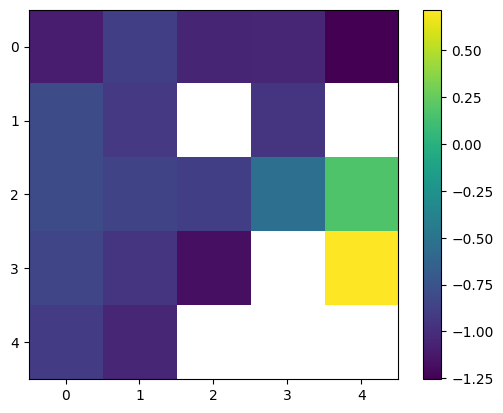

In [7]:
""" Test an example with a 'magnetic' agent that uses a policy that says to move towards the win state """
V = monte_carlo_simulation(g, MagneticAgent(g.win_state), 0.95, 500)
print_matrix(V)
plt.imshow(V)
plt.colorbar()
plt.show()

In [332]:
def approximate_q(gridworld, agent, gamma=0.95, num_episodes=500, track=False):
    """Approximates Q, a gridworld.width by gridworld.height by actions matrix that 
       contains the average returns from taking each action in each of the possible
       grid states across num_episodes """
    
    """Initialize Q and returns as matrices that are width * height * actions to store returns
       calculated during each episode. For each state/action pair in the returns matrix, a list 
       of returns for each episode will accumulate. For each state/action pair in the Q matrix,
       the average return across episodes will be stored. A list of wallclock_times are stored
       to keep track of the time elapsed per episode"""
    Q = [[ {} for _ in range(gridworld.width)] for _ in range(gridworld.height)]
    returns = [[ { } for _ in range(gridworld.width)] for _ in range(gridworld.height)]
    episode_returns = []
    avg_returns_per_episode = []
    wallclock_times = []
    
    """Attach the agent to the gridworld"""
    gridworld.set_agent(agent)
    
    """Loop until all episodes are complete """
    completed_episodes = 0
    start_time = time.time()
    epsilon = 0.9
    
    while completed_episodes < num_episodes:
        """Initialize the time step (t) for the current episode and create lists to store
            visited states and taken actions (index matched) """
        time_step = 0
        visited_states_and_taken_actions = list()
        
        """Get a random valid state to place the agent in and select a first action """
        random_start(gridworld)
        selected_action = random.choice(gridworld.agent.available_actions) 
        
        """The agent should act as long as it hasn't reached the terminal state"""
        while gridworld.agent.state != gridworld.win_state:
            """Calculate the reward for the move. Incorporate this reward into the rewards of all states
               that have been visited so far this episode."""
            
            reward_from_action = gridworld.reward(selected_action)

            for i in range(len(visited_states_and_taken_actions)):
                state_in_history = visited_states_and_taken_actions[-1*i] # moving backwards in time
                state_in_history[1] += gamma**i * reward_from_action # element 1 is the cumulative reward
                
            """Store the current state/action pair """
            visited_states_and_taken_actions.append([(gridworld.agent.state, selected_action), reward_from_action])
            
            """Make the move and increase the time step."""
            gridworld.move(selected_action)
            time_step += 1
            
            """Set the next selected action """
            selected_action = gridworld.agent.get_action_from_policy(Q[gridworld.agent.state[0]]
                                                                     [gridworld.agent.state[1]], epsilon)
            
        """After every episode, add the rewards for each visited state into the returns 3-D array (indexed
           by (row, col)). Then recalculate Q based on the ever growing returns lists. As they grow, the
           values in Q should converge."""
        
        """The return of the episode == The return of the initial (s, a) pair that we chose.
        I considered summing all returns from the episode but I don't think that's right."""
        episode_returns.append(visited_states_and_taken_actions[0][1])
        avg_returns_per_episode.append(average(episode_returns))
        
        for i in range(1, len(visited_states_and_taken_actions)):
            step_T_minus_i = visited_states_and_taken_actions[-1*i]
            visited_state, taken_action = step_T_minus_i[0]
            if (visited_state, taken_action) in map(lambda l : l[0], visited_states_and_taken_actions[0:-1*i]):
                continue

            rewards = step_T_minus_i[1]
            if taken_action not in returns[visited_state[0]][visited_state[1]]:
                returns[visited_state[0]][visited_state[1]][taken_action] = []
            returns[visited_state[0]][visited_state[1]][taken_action].append(rewards)
            Q[visited_state[0]][visited_state[1]][taken_action] = average(returns[visited_state[0]][visited_state[1]][taken_action])
        
        
        #avg_returns_per_episode.append(average(returns_per_visited_state))
        wallclock_times.append(time.time() - start_time)
        epsilon *= 0.999
        completed_episodes += 1
        
        if track and completed_episodes % 100 == 0:
            print(f"Completed episodes: {completed_episodes}")
        
    return (Q, avg_returns_per_episode, wallclock_times)


In [333]:
"""Test approximate_q"""
random.seed(0)
height = 5
width = 5
num_episodes = 5000
g = GridWorld(height, width, complex=True)
print(g) # print the gridworld

# here, returns is an average return value over the entire grid for each episode.
# (ex. returns[0] is the avg. return from ep 1, returns[1] is the avg. return from ep 2)
(Q, returns, times) = approximate_q(g, ArgMaxAgent(), num_episodes=num_episodes, track=True)

| | | | | |
| | |█| |█|
| | | | | |
| | | |W| |
|*| |*| | |
Completed episodes: 100
Completed episodes: 200
Completed episodes: 300
Completed episodes: 400
Completed episodes: 500
Completed episodes: 600
Completed episodes: 700
Completed episodes: 800
Completed episodes: 900
Completed episodes: 1000
Completed episodes: 1100
Completed episodes: 1200
Completed episodes: 1300
Completed episodes: 1400
Completed episodes: 1500
Completed episodes: 1600
Completed episodes: 1700
Completed episodes: 1800
Completed episodes: 1900
Completed episodes: 2000
Completed episodes: 2100
Completed episodes: 2200
Completed episodes: 2300
Completed episodes: 2400
Completed episodes: 2500
Completed episodes: 2600
Completed episodes: 2700
Completed episodes: 2800
Completed episodes: 2900
Completed episodes: 3000
Completed episodes: 3100
Completed episodes: 3200
Completed episodes: 3300
Completed episodes: 3400
Completed episodes: 3500
Completed episodes: 3600
Completed episodes: 3700
Completed episodes: 3800

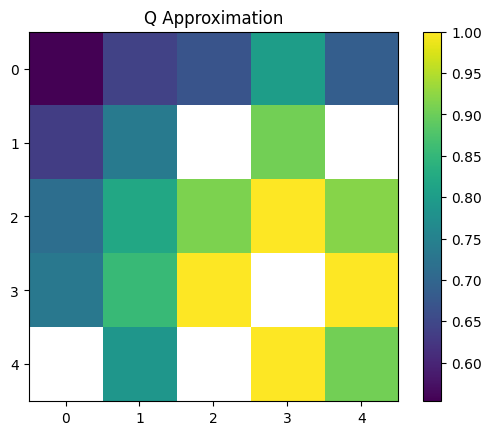

|→|↓|→|↓|←|
|↓|↓|█|↓|█|
|→|→|→|↓|↓|
|→|→|→|█|←|
|█|↑|█|↑|↑|


In [334]:
# plot maximum Q values
(q_values, actions) = max_q(Q)
plt.imshow(q_values)
plt.colorbar()
plt.title("Q Approximation")
plt.show()
print_policy_from_q(Q)

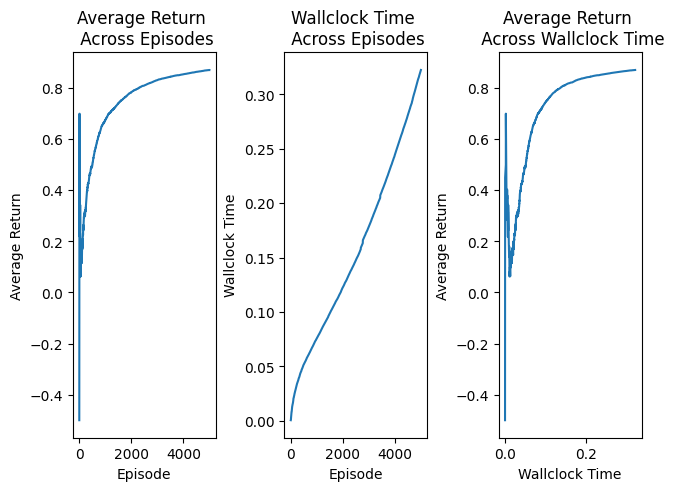

In [335]:
# 
fig, axs = plt.subplots(1,3,layout='constrained')
# plot of average return per episode

avg_returns_by_episode = []

i = 0

# calculate avg returns by episode, which is the average return for different
# sized 'bins' (examples: ep1, ep1-10, ep1-100)
for r in returns:
    avg_returns_by_episode.append(average(returns[:i]))
    i+=1
    
axs[0].title.set_text('Average Return \n Across Episodes')
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Average Return")
axs[0].plot(range(num_episodes), returns) #avg_returns_by_episode)

axs[1].title.set_text('Wallclock Time \n Across Episodes')
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Wallclock Time")
axs[1].plot(range(num_episodes), times)

axs[2].title.set_text('Average Return \n Across Wallclock Time')
axs[2].set_xlabel("Wallclock Time")
axs[2].set_ylabel("Average Return")
axs[2].plot(times, returns) # avg_returns_by_episode)

plt.show()